In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
simpsons_episodes = pd.read_pickle("./data/simpsons_processed.pkl")

In [3]:
simpsons_episodes.head()

,season,episode,title,airdate,rating,total_votes,desc,director,writer,prod_code,viewers,ep_overall,As_Themselves,Character_Played,Homer_main,Marge_main,Bart_main,Lisa_main,Maggie_main,Treehouse
0,1,1,Simpsons Roasting on an Open Fire,1989-12-17,8.1,8400,Homer is forced to become a department store S...,[David Silverman],[Mimi Pond],7G08,26.7,1,0,0,1,1,1,0,0,0
1,1,2,Bart the Genius,1990-01-14,7.6,5700,Bart ends up at a school for gifted children a...,[David Silverman],[Jon Vitti],7G02,24.5,2,0,0,0,0,1,0,0,0
2,1,3,Homer's Odyssey,1990-01-21,7.3,5000,"After losing his job, Homer contemplates endin...",[Wes Archer],"[Jay Kogen, Wallace Wolodarsky]",7G03,27.5,3,0,1,1,0,0,0,0,0
3,1,4,There's No Disgrace Like Home,1990-01-28,7.6,4900,After being embarrassed by the rest of the fam...,"[Kent Butterworth, Gregg Vanzo]","[Al Jean, Mike Reiss]",7G04,20.2,4,0,0,1,0,0,0,0,0
4,1,5,Bart the General,1990-02-04,7.9,5300,After being beaten up by Nelson Muntz one too ...,[David Silverman],[John Swartzwelder],7G05,27.1,5,0,0,0,0,1,0,0,0


In [4]:
simpsons_episodes.rating = simpsons_episodes.rating.astype('float')
simpsons_episodes.viewers = simpsons_episodes.viewers.astype('float')

In [6]:
simpsons_episodes['votes_k'] = simpsons_episodes.total_votes.apply(lambda x: x/1000)
simpsons_episodes['title'] = simpsons_episodes.title.apply(lambda x: x.strip())
simpsons_episodes['date_format'] = simpsons_episodes.airdate.apply(lambda x: x.strftime("%a %d %b %Y"))

In [7]:
# There is an episode (S28E12&13) that is actually a two parter. Therefore, duplicate the details (but add part 1 and 2 to title)

mask1 = (simpsons_episodes.season==28)
mask2 = (simpsons_episodes.episode==12)
two_parter = simpsons_episodes[mask1 & mask2].copy()
simpsons_episodes['title'] = np.where(mask1 & mask2, "The Great Phatsby (part 1)", simpsons_episodes['title'])
two_parter.title = "The Great Phatsby (part 2)"
two_parter.episode = 13
simpsons_episodes_full = pd.concat([simpsons_episodes, two_parter])
simpsons_episodes_full.reset_index(drop=True, inplace=True)

# BERTopic

Using the episode title and description, what topics does BERTopic produce?
- Plot these topics in 3D for visualization
- What do these topics generally represent?
- What are the average ratings/viewerships of these topics?

In [8]:
!pip install bertopic

Defaulting to user installation because normal site-packages is not writeable
  Using cached bertopic-0.15.0-py2.py3-none-any.whl (143 kB)
  Using cached sentence_transformers-2.2.2-py3-none-any.whl
  Using cached transformers-4.35.0-py3-none-any.whl (7.9 MB)


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [9]:
!pip install -U sentence-transformers

Defaulting to user installation because normal site-packages is not writeable


In [12]:
from sentence_transformers import SentenceTransformer
sent_model = SentenceTransformer('all-MiniLM-L6-v2')

In [71]:
# Create corpus
simpsons_episodes['corpus'] = simpsons_episodes['title'] + ' ' + simpsons_episodes['desc']

In [72]:
sent_embeddings = sent_model.encode(simpsons_episodes['corpus'])

In [73]:
from sklearn.manifold import TSNE

tsne_model_3d = TSNE(perplexity=15, n_components=3,
                     init='pca', n_iter=3500, random_state=42)
tsne_embeddings_3d = tsne_model_3d.fit_transform(sent_embeddings)

In [96]:
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic 

vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1,2))
topic_model = BERTopic(nr_topics = 'auto', vectorizer_model=vectorizer_model, min_topic_size=8)
topics, probs = topic_model.fit_transform(simpsons_episodes['corpus'], sent_embeddings)

In [97]:
import plotly.graph_objects as go
from typing import List
import textwrap

def visualize_episodes(
    topic_model,
    docs: List[str],
    reduced_embeddings: np.ndarray = None,
    hide_annotations: bool = False,
    hide_document_hover: bool = False,
    title: str = "Episode topics",
    width: int = 1200,
    height: int = 750
):
    title_text = "<b>" + title
    
    topic_per_doc = topic_model.topics_
    
    df = docs[['season', 'episode', 'title', 'date_format', 'rating', 'total_votes', 'desc']]
    df['topic'] = pd.DataFrame({'topic': topic_per_doc})
    
    df['x'] = reduced_embeddings[:,0]
    df['y'] = reduced_embeddings[:,1]
    df['z'] = reduced_embeddings[:,2]
    
    df['se'] = df.apply(lambda x: "<b>Episode:</b> S" + str(x['season']) + "E" + str(x['episode']) + "<br>", axis=1)
    df['title'] = df['title'].apply(lambda x: "<b>" + x + "</b><br>")
    df['date_format'] = df['date_format'].apply(lambda x: "<b>Airdate:</b>" + str(x) + "<br>")
    df['desc'] = df['desc'].apply(lambda x: "<b>Description:</b>" + x + "<br>")
    df['desc'] = df['desc'].apply(lambda txt: '<br>'.join(textwrap.wrap(txt, width=50)))
    
    unique_topics = set(topic_per_doc)
    
    # Prepare topic names as they appear on legend
    names = [f"{topic}_" + "_".join([word for word, value in topic_model.get_topic(topic)][:3]) for topic in unique_topics]
                                    
    fig = go.Figure()
    
    # Outliers
    non_selected_topics = [-1]
    
    selection = df[df['topic'].isin(non_selected_topics)]
    selection['text'] = ''
    selection.loc[len(selection), :] = ["", "", "", "", "", "", "", "", "", selection.x.mean(), selection.y.mean(), selection.z.mean(), 'Unselected']
    
    # Plot the unselected topics
    fig.add_trace(
        go.Scatter3d(
            x = selection.x,
            y = selection.y,
            z = selection.z,
            customdata = selection[['title', 'se', 'date_format', 'desc']],
            hovertemplate = 
                "%{customdata[0]}" +
                "%{customdata[1]}" +
                "%{customdata[2]}" +
                "%{customdata[3]}" +
                "<extra></extra>",
            text = selection.text,
            mode = 'markers+text',
            name = "Unselected",
            showlegend=True,
            textfont = dict(
                size = 12,
            ),
            marker = dict(color='#CFD8DC', size=5, opacity=0.75)
        )
    )
    
    # Selected topics
    for name, topic in zip(names, unique_topics):
        if topic in topics and topic != -1:
            selection = df[df['topic']==topic]
            selection['text'] = ''
            
            if not hide_annotations:
                selection.loc[len(selection), :] = ["", "", "", "", "", "", "", "", "", selection.x.mean(), selection.y.mean(), selection.z.mean(), name]
                
            fig.add_trace(
                go.Scatter3d(
                    x = selection.x,
                    y = selection.y,
                    z = selection.z,
                    customdata = selection[['title', 'se', 'date_format', 'desc']],
                    hovertemplate = 
                        "%{customdata[0]}" +
                        "%{customdata[1]}" +
                        "%{customdata[2]}" +
                        "%{customdata[3]}" +
                        "<extra></extra>",
                    text = selection.text,
                    mode = 'markers+text',
                    name = name,
                    textfont = dict(
                        size = 12,
                    ),
                    marker = dict(size=5, opacity=0.75)
                )
            )
            
    # Stylize layout
    fig.update_layout(
        template="simple_white",
        title={
            'text': title_text,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(
                size=22,
                color="Black")
        },
        width = width,
        height = height
    )
    
    return fig
    

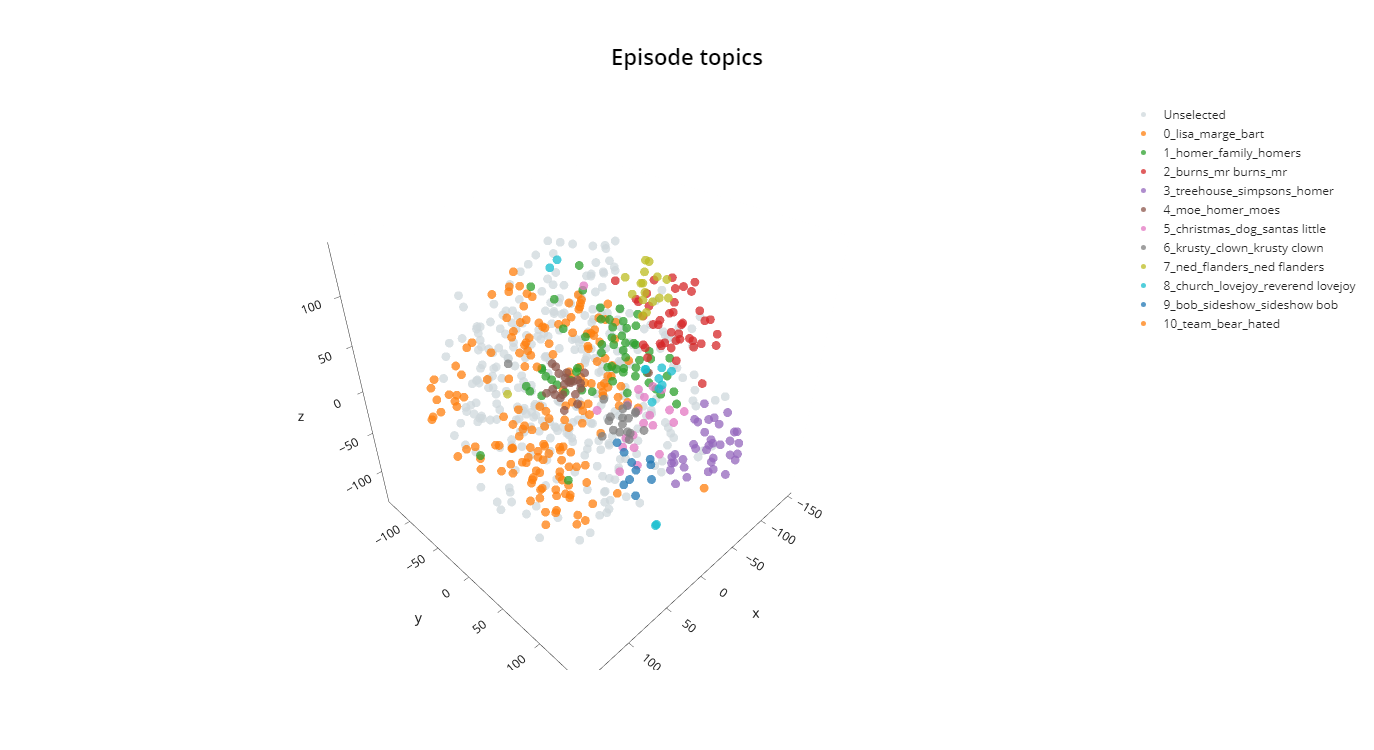

In [98]:
visualize_episodes(topic_model, simpsons_episodes, reduced_embeddings = tsne_embeddings_3d)